https://arxiv.org/pdf/2104.10470  
https://arxiv.org/pdf/1602.01260

# Detrended Fluctuation Analysis (DFA)

**Detrended Fluctuation Analysis (DFA)** is a method for analyzing time series to detect long-range dependencies. It can distinguish between intrinsic self-similarity (fractal properties) and external trends in non-stationary time series.

## Steps in DFA:
1. Integration of the Time Series:
    - Calculate the cumulative sum (integrated series) of the deviations of the time series from its mean. $$Y(k) = \sum_{i=1}^k(x_i - \bar x)$$
    
2. Division into Boxes:
    - Divide the integrated time series into non-overlapping segments of equal length $n$
3. Detrending:
    - In each segment, fit a polynomial trend (often linear) to the data. The order of the polynomial can be adjusted according to the nature of the trend.
    - Subtract the local trend from the data within each segment to obtain the detrended series.
4. Fluctuation Calculation:
    - Calculate the root-mean-square fluctuation of the detrended series for each segment. $$F(n) = \sqrt{\frac{1}{N}\sum_{k=1}^N[Y(k) - Y_{\text{trend}}(k)]^2}$$
    
5. Scaling Behavior:
    - Repeat the process for different segment sizes $n$ and plot $\log F(n)$ versus $\log n$.
    - The slope of the line in this log-log plot gives the Hurst exponent, indicating the presence of long-range correlations.
    
    
## Interpretation
- Log-Log Plot:
    - The plot of $\log F(n)$ vs $\log n$ should be approximately linear.
    - The slope of this line is the Hurst exponen $H$.
- Hurst Exponent:
    - $H\approx 0.5$: No long memory (random walk).
    - $H < 0.5$: Anti-persistent behavior.
    - $H > 0.5$: Persistent behavior (long memory).

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')

In [2]:
def dfa(time_series, min_window=5, max_window=50):
    N = len(time_series)
    fluctuations = []

    for n in range(min_window, max_window):
        Y = np.cumsum(time_series - np.mean(time_series))
        segments = N // n
        F_n = []

        for i in range(segments):
            segment = Y[i*n:(i+1)*n]
            x = np.arange(n)
            p = np.polyfit(x, segment, 1)
            trend = np.polyval(p, x)
            F_n.append(np.sqrt(np.mean((segment - trend)**2)))

        fluctuations.append(np.sqrt(np.mean(np.array(F_n)**2)))

    return fluctuations, range(min_window, max_window)

## Data Downloading

In [3]:
# Download historical stock prices
symbol = 'BTC-USD'
ticker = yf.Ticker(symbol)
data = ticker.history(start='2020-01-01', end='2024-01-01', interval='1d')
data['Returns'] = data['Close'].pct_change().dropna()

## Returns

In [4]:
# Perform DFA on returns
returns = data['Returns'].dropna().values
fluctuations, window_sizes = dfa(returns)

In [5]:
len(fluctuations), window_sizes

(45, range(5, 50))

In [6]:
# Calculate Hurst exponent
hurst_exponent = np.polyfit(np.log(window_sizes), np.log(fluctuations), 1)[0]
print(f"Hurst Exponent for {symbol} Returns: {hurst_exponent}")

Hurst Exponent for BTC-USD Returns: 0.5401513141557672


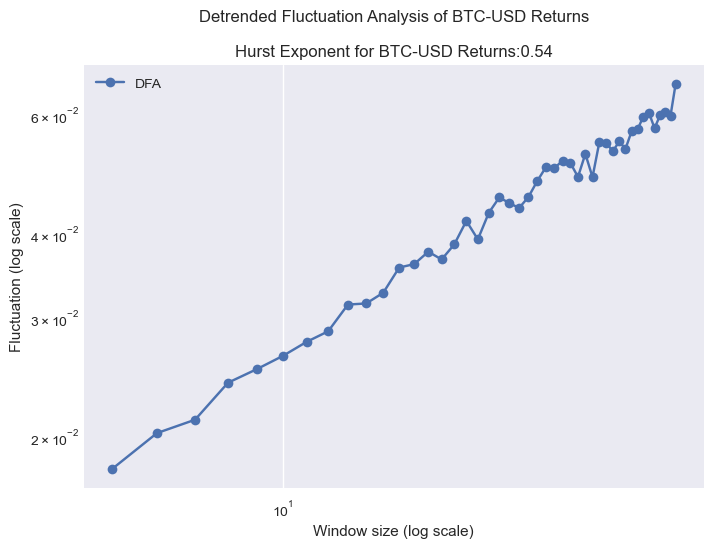

In [7]:
# Plot the results
plt.loglog(window_sizes, fluctuations, 'o-', label='DFA')
plt.xlabel('Window size (log scale)')
plt.ylabel('Fluctuation (log scale)')
plt.title(f'Detrended Fluctuation Analysis of {symbol} Returns\n\nHurst Exponent for {symbol} Returns:{hurst_exponent:.2f}')
# plt.grid(True)
plt.legend()
plt.savefig('btc-return-dfa.png')
plt.show()

## Volatility

In [8]:
# Perform DFA on squared returns (volatility)
volatility = returns ** 2
fluctuations, window_sizes = dfa(volatility)

In [9]:
len(fluctuations), window_sizes

(45, range(5, 50))

In [10]:
# Calculate Hurst exponent
hurst_exponent = np.polyfit(np.log(window_sizes), np.log(fluctuations), 1)[0]
print(f"Hurst Exponent for {symbol} Returns: {hurst_exponent}")

Hurst Exponent for BTC-USD Returns: 0.6930410965892374


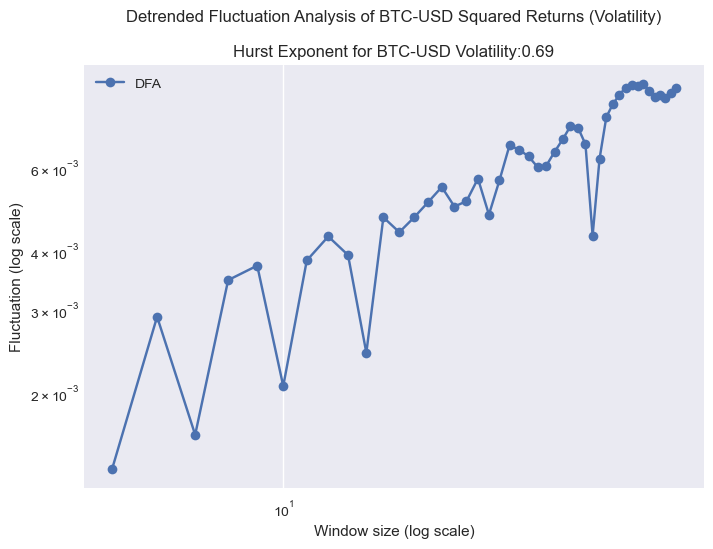

In [11]:
# Plot the results
plt.loglog(window_sizes, fluctuations, 'o-', label='DFA')
plt.xlabel('Window size (log scale)')
plt.ylabel('Fluctuation (log scale)')
plt.title(f'Detrended Fluctuation Analysis of {symbol} Squared Returns (Volatility)\n\nHurst Exponent for {symbol} Volatility:{hurst_exponent:.2f}')
# plt.grid(True)
plt.legend()
plt.savefig('btc-vol-dfa.png')
plt.show()

In [12]:
from arch import arch_model

In [19]:
# Fit GARCH model
model_garch = arch_model(returns, vol='Garch', rescale=False)

In [20]:
res_garch = model_garch.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 199433505.05504864
Iteration:      2,   Func. Count:     17,   Neg. LLF: 4328056.304687699
Iteration:      3,   Func. Count:     28,   Neg. LLF: 19956.030397179886
Iteration:      4,   Func. Count:     39,   Neg. LLF: 38748581.92531656
Iteration:      5,   Func. Count:     50,   Neg. LLF: 10394694.215993354
Iteration:      6,   Func. Count:     61,   Neg. LLF: 4896.622045208532
Iteration:      7,   Func. Count:     71,   Neg. LLF: 647266319.5731413
Iteration:      8,   Func. Count:     82,   Neg. LLF: 496783.76550970896
Iteration:      9,   Func. Count:     94,   Neg. LLF: 94067.35505134903
Iteration:     10,   Func. Count:    104,   Neg. LLF: -2902.13557128599
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2902.1355680086617
            Iterations: 14
            Function evaluations: 104
            Gradient evaluations: 10


In [15]:
res_garch

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2902.14
Distribution:                  Normal   AIC:                          -5796.27
Method:            Maximum Likelihood   BIC:                          -5775.13
                                        No. Observations:                 1460
Date:                Mon, May 20 2024   Df Residuals:                     1459
Time:                        18:27:37   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.3269e-03  8.794e-04      2.646  8.141e-03 [6.

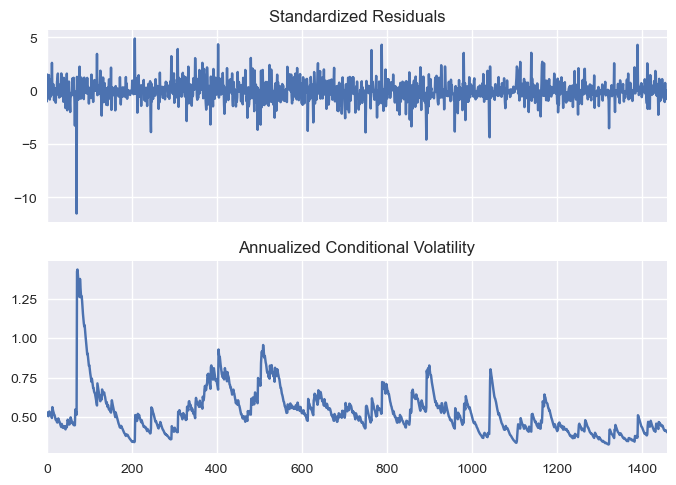

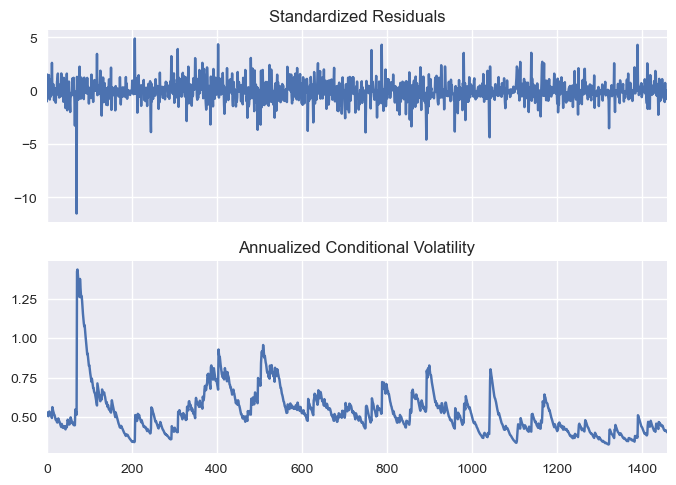

In [17]:
# Plot GARCH forecast
res_garch.plot(annualize='D')